In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
import numpy as np

In [166]:
## нормализация линий по возрасту и вычитание тренда литосферного остывания
from scipy import signal
import math
print(mag_ano.name.value_counts().sort_index().index)
chrons= dict(zip(mag_ano.name.value_counts().sort_index().index, [978,1972,3315,4014,4343,4572,4734,4934,5398]))

def make_normalised_line(name):
    one_line=result[result['line']==name]
    chrons_on_line=one_line[one_line['name'].notnull()].name.values
    if chrons[chrons_on_line[0]]<chrons[chrons_on_line[-1]]:
        print('reverse!!')
        one_line=one_line.reindex(index=one_line.index[::-1])
        one_line.index=range(len(one_line))
        chrons_on_line=one_line[one_line['name'].notnull()].name.values
    index=one_line[one_line['name'].notnull()].name.index
    min_chron=one_line[one_line['name'].notnull()].index.min()
    max_chron=one_line[one_line['name'].notnull()].index.max()
    one_line=one_line.loc[min_chron:max_chron]
    one_line.index=range(len(one_line))
    index=one_line[one_line['name'].notnull()].name.index
    new_depth=[]
    regression=[]
    space_on_start=5398-chrons[chrons_on_line[0]]
    new_depth.extend([np.NAN for i in range(space_on_start)])
    regression.extend([np.NAN for i in range(space_on_start)])

    for i in range(len(index)-1):
        one_step=one_line[index[i]:index[i+1]]
        f=signal.resample(one_step.depth_x,chrons[chrons_on_line[i]]-chrons[chrons_on_line[i+1]])
        new_depth.extend(f)
    model = LinearRegression()
    model.fit(np.arange(len(new_depth)-space_on_start)[:, None], new_depth[space_on_start:])
#     regression.extend(model.predict(np.arange(0,len(new_depth)-space_on_start)[:, None]))

    if name=='Arc11029':
        a=np.polyfit(np.sqrt(np.arange(len(new_depth)-space_on_start)), new_depth[space_on_start:],1)
        regression.extend([a[0]*np.sqrt(i)+a[1] for i in np.arange(len(new_depth)-space_on_start)])
    else:
        a=np.polyfit(np.power(np.arange(len(new_depth)-space_on_start),2), new_depth[space_on_start:],1)
        regression.extend([a[0]*np.power(i,2)+a[1] for i in np.arange(len(new_depth)-space_on_start)])
    if len(new_depth)<5398:
        space_on_end=len(new_depth)   
        new_depth.extend([np.NAN for i in range(5398-len(new_depth))])
        regression.extend([np.NAN for i in range(5398-len(regression))])
    new_depth=pd.DataFrame(new_depth,columns=['depth'])    
    new_depth['regression']=regression
    new_depth['diff']=new_depth['depth']-new_depth['regression']
    new_depth.loc[range(space_on_start),'diff']=np.NAN
    new_depth.loc[range(space_on_end,5398),'diff']=np.NAN
    plt.figure(figsize=(13,7))
    plt.plot(-new_depth['diff']/2,label='detrended basement topography')
    plt.plot(-new_depth.loc[space_on_start:space_on_end-5]['regression']/2,label='trend line (cooling)')
    plt.plot(-new_depth.loc[space_on_start:space_on_end-5]['depth']/2,label='basement topography')
    plt.ylabel('depth in time (ms)',{'fontsize':14})
    plt.xlabel('normalised age, linear scale (not distance in km!)',{'fontsize':14})
    plt.xticks([5398-chrons[i] for i in chrons_on_line],list(chrons_on_line))
    plt.legend()
    if name=='Arc11006':
        plt.savefig('example.jpg',dpi=450)
    plt.show()
    return(new_depth,model.coef_)
# Функция ресэмплинга, есть встроенная 
# new_depth=[]
# for i in range(chrons[indexes[0]],chrons[indexes[1]]+1):
#     print(i)
#     one_step=one_line[index[0]:index[1]]
#     position=i/(chrons[indexes[1]]+1)*len(one_step)
#     value=one_step.loc[int(math.floor(position)),'depth_x']+(int(math.ceil(position))-int(math.floor(position)))*(position%1)
#     new_depth.append(value)


Index(['C05ny', 'C06no', 'C13ny', 'C16ny', 'C20no', 'C21any', 'C21no', 'C22no',
       'C24no'],
      dtype='object')


In [165]:
# чтение файлов с фундаментом и магнитными аномалиями
data=pd.read_csv('acoustic_basement_3.dat', sep=' ',usecols=(0,1,2,4),names=('x','y','line','depth'))
mag_ano=pd.read_csv('magn_ano_2.dat',sep=' ',encoding='cp1251',skiprows=range(0,11),usecols=(0,1,2,6),names=('x','y','depth','name'))

## пересечение аномалий и профилей
## если точка аномалии расположена ближе 8 км к профилю, то ближайшей точке на профиле присваивается эта аномалия
for i in mag_ano.index:
    x=mag_ano.loc[i,'x']
    y=mag_ano.loc[i,'y']
    data['x_new']=abs(data.x-x)
    data['y_new']=abs(data.y-y)
    data['dist']=(data['x_new']**2+data['y_new']**2)**0.5
    min_dist=data['dist'].min()
    if min_dist<8000:
        mag_ano.loc[i,'x']=data[data.dist==min_dist]['x'].values[0]
        mag_ano.loc[i,'y']=data[data.dist==min_dist]['y'].values[0]
result=pd.merge(data,mag_ano,left_on=['x','y'],right_on=['x','y'],how='outer')
result=result[['x','y','line','depth_x','name']]
result.dropna(subset=['line'],inplace=True)

##Разделение профиля Arc14_P07 на две части!
# print(result[result.line=='Arc11004'].head(20))
add_part_1=result[result.line=='Arc11004_2']
add_part_2=result[result.line=='Arc11004']
add_part_1.line='Arc11004'
add_part_2=add_part_2.append(add_part_1,ignore_index=True)
add_part_2.index=[add_part_2.index.min()+i for i in range(add_part_2.index.max()-add_part_2.index.min()+1)]
result=result[~result.line.isin(['Arc11004_2','Arc11004'])]
result=result.append(add_part_2)
result.loc[135938:143673,'line']='Arc14_P07west'

result.replace('Arc11005_2','Arc11005',inplace=True)
# print(result[result.line=='Arc11004'].head(20))

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Arc11003


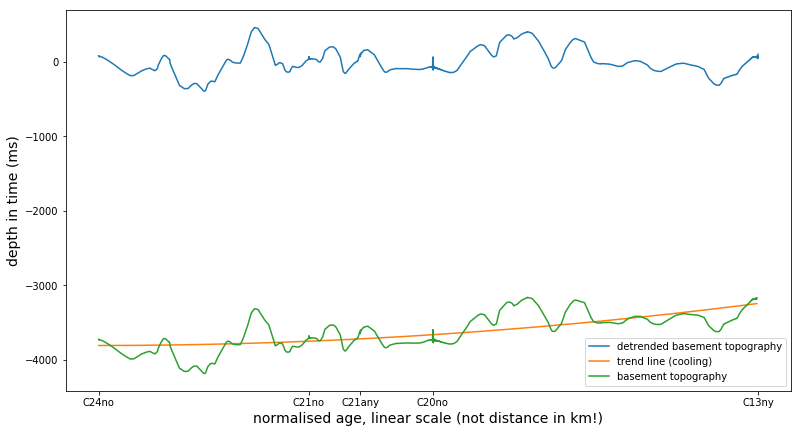

-0.601578422690529
Arc11035
reverse!!


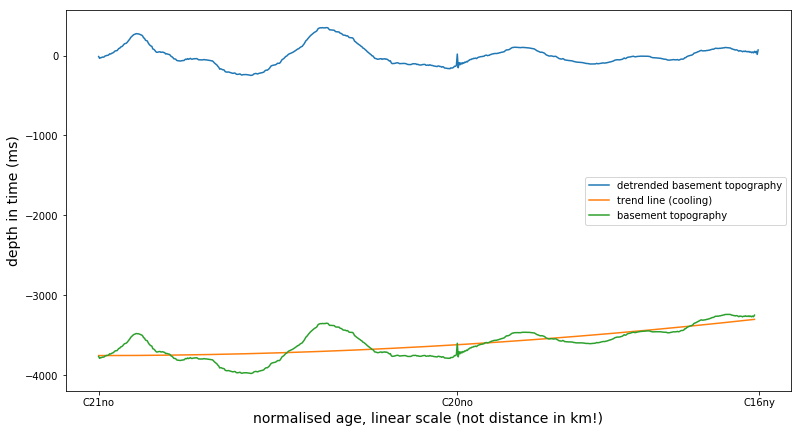

-1.2259436722828578
Arc11005


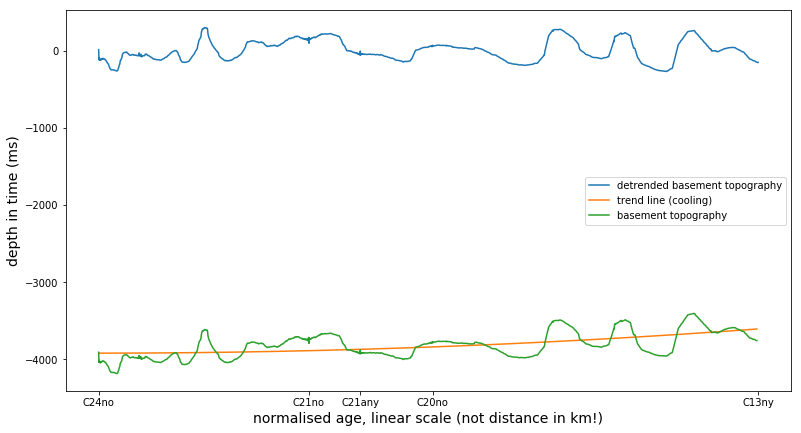

-0.32363576935854566
Arc11006


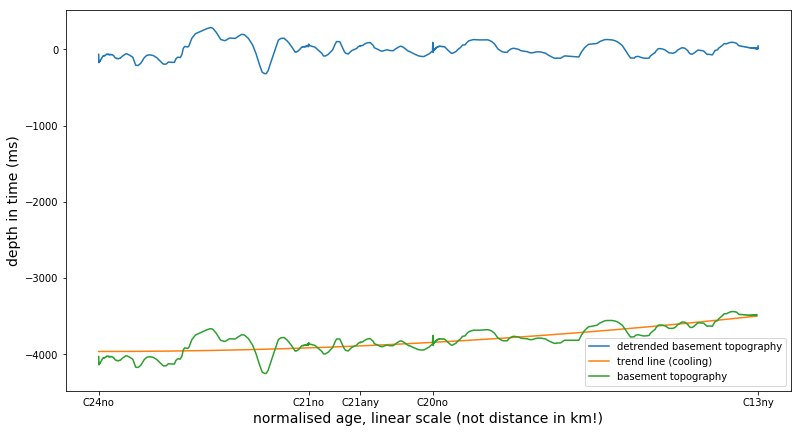

-0.46141973211111426
Arc11006_10
reverse!!


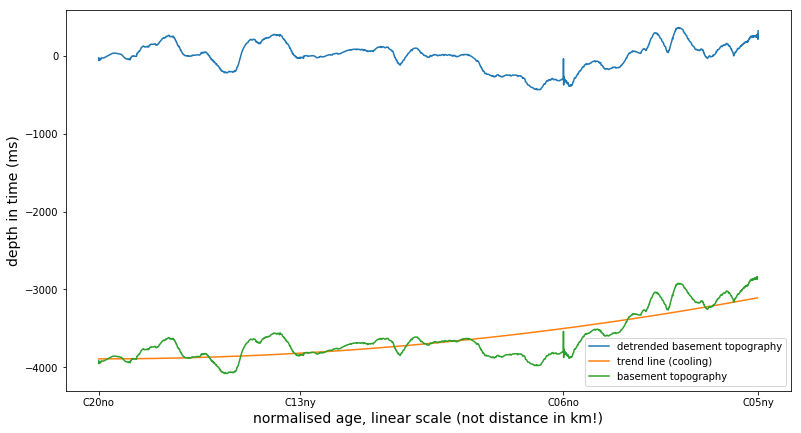

-0.43228247767119504
Arc11024


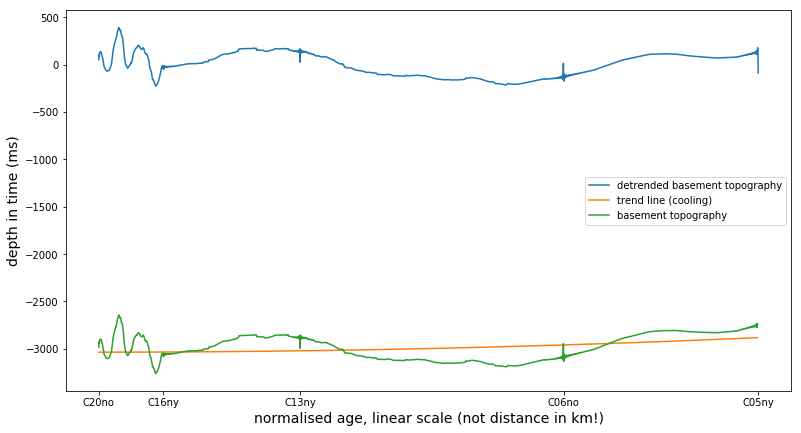

-0.053783853294659754
Arc11027


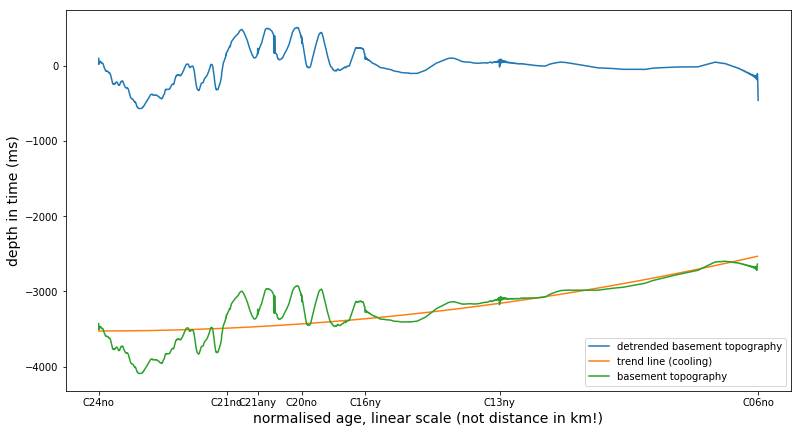

-0.624996766844959
Arc11028
reverse!!


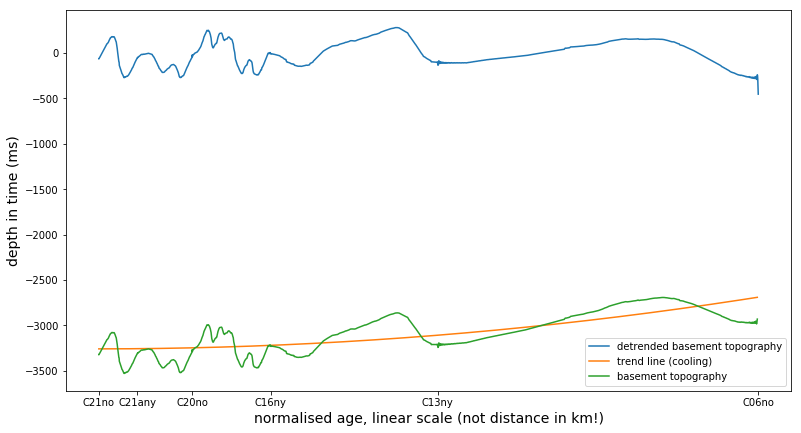

-0.4400780498770995
Arc11029


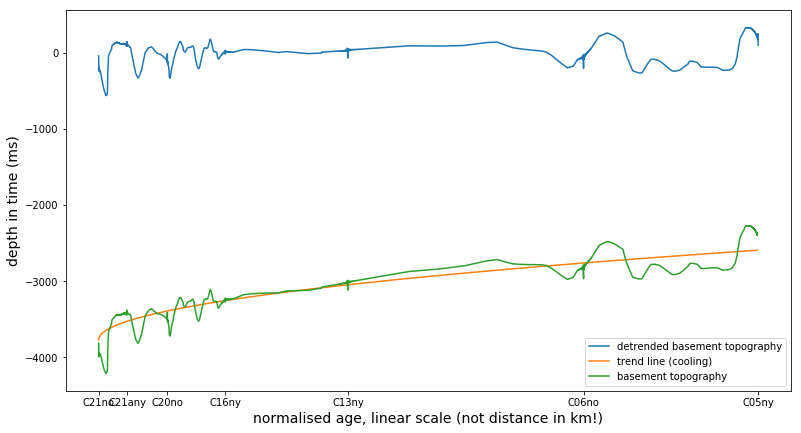

-0.4830845607494074
Arc11030
reverse!!


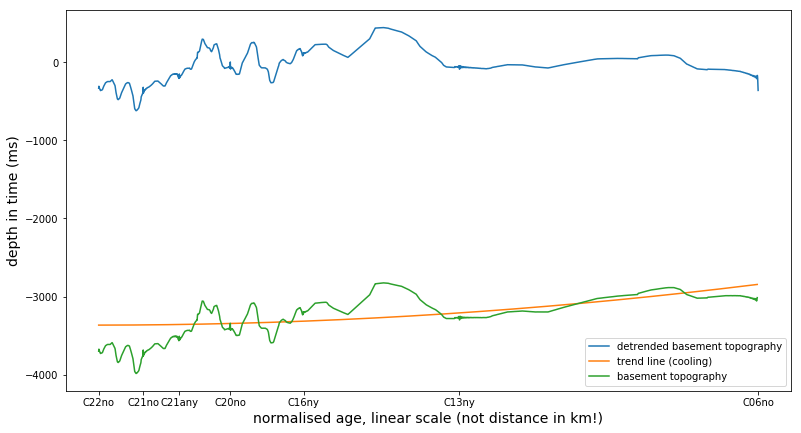

-0.42176119376858723
Arc11031


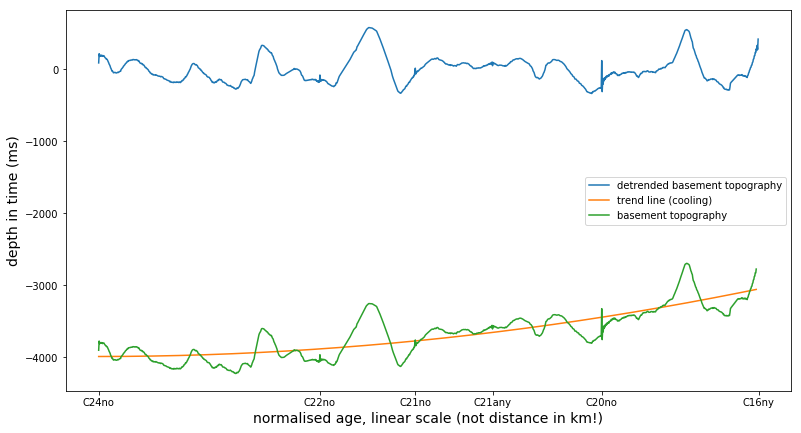

-1.3779764826243153
Arc11032
reverse!!


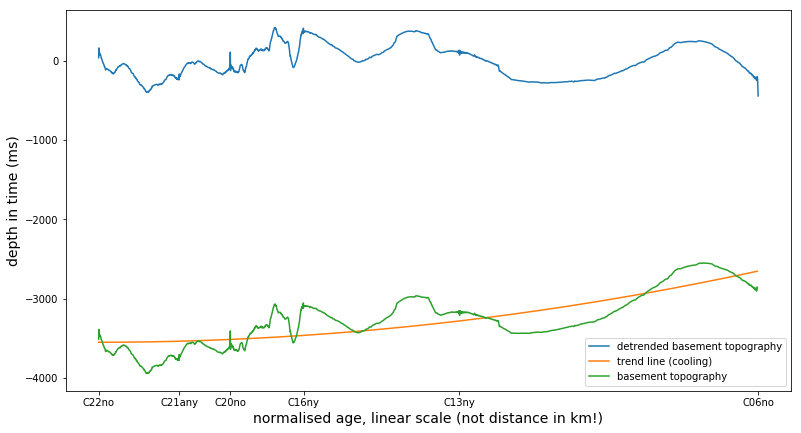

-0.635069200267166
Arc11034


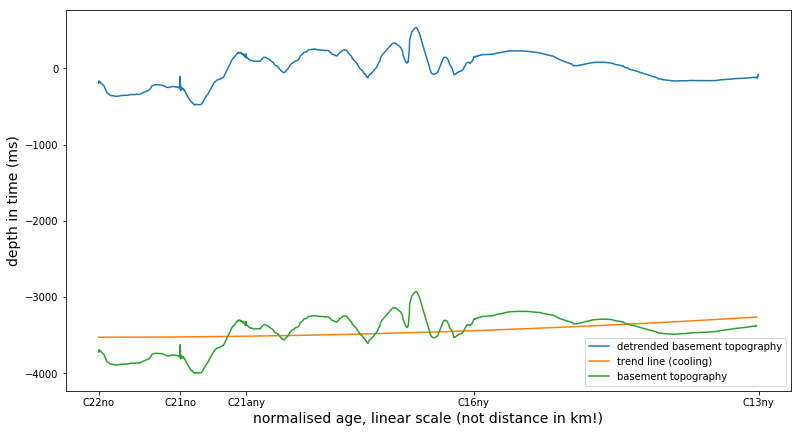

-0.5038678571700805
Arc14_P07
reverse!!


ValueError: could not broadcast input array from shape (2145) into shape (0)

In [167]:
## Нормализация всех профилей с индексацией по 10000 лет. Каждый индекс - 
## среднее значение фундамента за возрастной интервал 10000 лет
result_DB=pd.DataFrame([np.NAN for i in range(5398)],columns=['res'])
reg_DB=pd.DataFrame([np.NAN for i in range(5398)],columns=['res'])
lines=dict()
for i in result.line.unique():
    if i not in ['Arc11005_04','Arc11006_02','Arc11005_06']:
        print(i)
        df,coef=make_normalised_line(i)
        print(coef[0])
        lines[i]=coef[0]
        result_DB[i]=df['diff']
        reg_DB[i]=df['regression']

In [1176]:
## Разная глупая статистика по нормализованным профилям

result_DB=result_DB.transpose()
mean=result_DB.mean(skipna=True)
median=result_DB.median(skipna=True)
std=result_DB.std(skipna=True)
summ=result_DB.sum(skipna=True)
result_DB=result_DB.transpose()
result_DB['mean']=mean
result_DB['med']=median
result_DB['std']=std
result_DB['summ']=summ

In [48]:
## Вычисление RMS шероховатости фундамента

def calc_roughness(row):
    return(result_DB[int(row['start']):int(row['end'])][i].std())

## подготовка таблицы RMS
a=[5398-i for i in chrons.values()]
a.reverse()
RMS=pd.DataFrame(a,columns=['start'])
RMS['end']=RMS['start'].shift(-1)
RMS.fillna(5398,inplace=True)
## Заполнение таблицы RMS на основе линий в result
for i in result.line.unique():
    if i not in ['Arc11005_04','Arc11006_02','Arc11005_06']:
        RMS[i]=RMS.apply(calc_roughness,axis=1)
RMS['age']=chrons.keys()
RMS['age']=RMS['age'][::-1].values
RMS.drop(8,inplace=True)
RMS

,start,end,Arc11003,Arc11035,Arc11005,Arc11006,Arc11006_10,Arc11024,Arc11027,Arc11028,Arc11029,Arc11030,Arc11031,Arc11032,Arc11034,Arc14_P07,Arc14_P07west,Arc11026,Arc11004,age
0,0,464.0,279.030181,NaN,221.245866,312.395312,NaN,NaN,347.632439,NaN,NaN,NaN,280.614301,NaN,NaN,315.784634,117.938532,NaN,201.373442,C24no
1,464,664.0,404.100722,NaN,80.309335,287.988816,NaN,NaN,263.110848,NaN,NaN,230.089790,589.948503,194.836980,118.211339,352.679557,80.829068,NaN,150.905284,C22no
2,664,826.0,206.452261,280.978287,194.426775,105.735098,NaN,NaN,247.753144,308.210431,497.117134,128.538060,91.539413,139.743908,472.098942,205.001374,302.799947,103.109532,266.488731,C21no
3,826,1055.0,190.863694,357.424899,122.343290,103.425279,NaN,NaN,298.448777,167.229395,251.335526,283.426052,306.336716,110.461327,174.240140,181.011128,397.343128,86.530253,137.979332,C21any
4,1055,1384.0,376.201136,127.924826,195.037368,121.653222,150.932956,304.419508,305.117448,307.303502,224.714718,267.872277,378.150696,322.788930,329.075297,233.753420,214.376570,316.642125,477.254369,C20no
5,1384,2083.0,281.174213,NaN,320.413720,144.973028,302.962777,142.932499,130.634316,272.260862,30.638169,301.502005,NaN,254.246268,290.985641,711.221229,324.362870,261.979611,443.073814,C16ny
6,2083,3426.0,NaN,NaN,NaN,NaN,319.733244,184.745593,86.009554,243.190618,156.595759,139.127688,NaN,360.599601,NaN,495.609538,191.205186,109.270984,NaN,C13ny
7,3426,4420.0,NaN,NaN,NaN,NaN,353.275364,145.635969,NaN,NaN,382.172606,NaN,NaN,NaN,NaN,341.357149,368.518861,281.847228,NaN,C06no


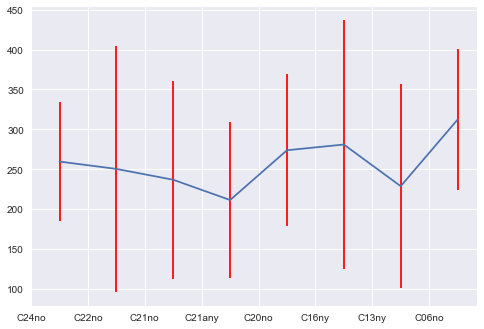

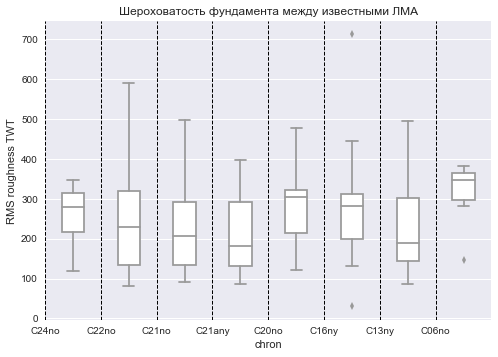

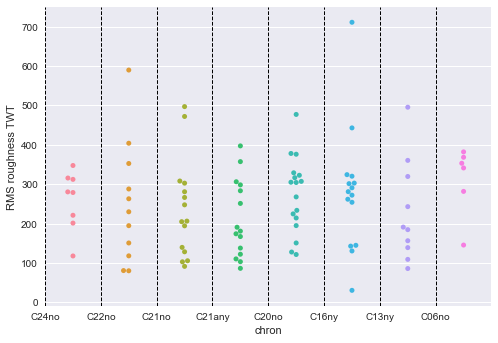

In [49]:
RMS[[i for i in RMS.columns if 'Arc' in i]].std(axis=1)
plt.errorbar(x=[i for i in range(8)],y=RMS[[i for i in RMS.columns if 'Arc' in i]].mean(axis=1),yerr=RMS[[i for i in RMS.columns if 'Arc' in i]].std(axis=1),ecolor='red')
plt.xticks([i-0.5 for i in range(8)],RMS.age)
plt.show()

import seaborn as sns

a=RMS.drop(labels=['start','end','age'],axis=1).unstack()
lines=[i[0] for i in a.index.tolist()]
c=[]
for i in range(17):
    c.extend(list(chrons.keys())[1:])
RMS_for_sns=pd.DataFrame(data=list(zip(lines,list(a.values),c[::-1])),columns=['line','RMS roughness TWT','chron'])

sns.boxplot(data=RMS_for_sns,x='chron',y='RMS roughness TWT',color='white',width=0.4)
plt.xticks([i-0.5 for i in range(9)],RMS.age)
for xc in [i-0.5 for i in range(8)]:
    plt.axvline(x=xc, color='k', linestyle='--',lw=1)
plt.title('Шероховатость фундамента между известными ЛМА')
plt.savefig('RMS_rough.jpg',dpi=450)    
plt.show()
sns.swarmplot(data=RMS_for_sns,x='chron',y='RMS roughness TWT')
plt.xticks([i-0.5 for i in range(9)],RMS.age)
for xc in [i-0.5 for i in range(8)]:
    plt.axvline(x=xc, color='k', linestyle='--',lw=1)
plt.savefig('RMS_rough_dots.jpg',dpi=450)   
plt.show()

In [349]:
def plot_one(name): 
    print(name)
    one_line=flat_basement[flat_basement['line']==name]
    plt.plot(one_line['diff'])
    for i in one_line[one_line.name.notnull()==True].index:
        plt.text(x=i,y=one_line.loc[i,'diff']-40,s=one_line.loc[i,'name'])
#     plt.plot(one_line['regression'])
    plt.show()

,Arc11003,Arc11005,Arc11006,Arc11006_10,Arc11004
0,312.976544,215.295951,274.614908,NaN,214.253407
1,382.232394,154.043475,356.465741,NaN,132.926789
2,190.387399,53.864518,115.201981,NaN,172.900960
3,175.829920,119.500102,90.198739,NaN,164.610240
4,376.520317,194.114737,143.166536,130.404683,355.296151
5,266.178259,311.862369,171.605685,302.463618,461.647787
6,52.087872,41.121117,42.614072,NaN,73.539777
7,NaN,NaN,NaN,NaN,NaN


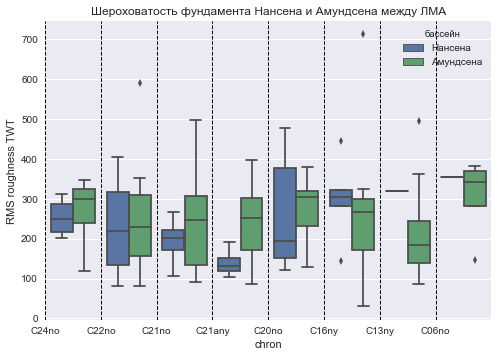

In [50]:
nansen=[i for i in RMS.columns if '00' in i]
amundsen=[i for i in RMS.columns if ('02' in i) or ('03' in i)]
a=RMS.drop(['start','end','age'],axis=1).unstack()

lines=[i[0] for i in a.index.tolist()]
c=[]
for i in range(17):
    c.extend(list(chrons.keys())[1:])
RMS_for_sns=pd.DataFrame(data=list(zip(lines,list(a.values),c[::-1])),columns=['line','RMS roughness TWT','chron'])
RMS_for_sns['бассейн']=RMS_for_sns['line'].apply(lambda x: 'Нансена' if x in nansen else 'Амундсена')
sns.boxplot(data=RMS_for_sns,x='chron',y='RMS roughness TWT',hue='бассейн')
plt.title('Шероховатость фундамента Нансена и Амундсена между ЛМА')
plt.xticks([i-0.5 for i in range(9)],RMS.age)
# plt.xlim(1.5,6.5)
for xc in [i-0.5 for i in range(8)]:
    plt.axvline(x=xc, color='k', linestyle='--',lw=1)
plt.savefig('RMS_rough.jpg',dpi=450)    
plt.show()

# a=RMS[nansen].unstack()
# lines=[i[0] for i in a.index.tolist()]
# c=[]
# for i in range(17):
#     c.extend(list(chrons.keys())[1:])
# RMS_for_sns=pd.DataFrame(data=list(zip(lines,list(a.values),c)),columns=['line','RMS roughness TWT','chron'])

# sns.boxplot(data=RMS_for_sns,x='chron',y='RMS roughness TWT',color='white',width=0.4)
# plt.xticks([i-0.5 for i in range(9)],RMS.age)
# for xc in [i-0.5 for i in range(8)]:
#     plt.axvline(x=xc, color='k', linestyle='--',lw=1)
# plt.savefig('RMS_rough.jpg',dpi=450)    
# plt.show()

C:\Users\FreimanS\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in power
  # This is added back by InteractiveShellApp.init_path()


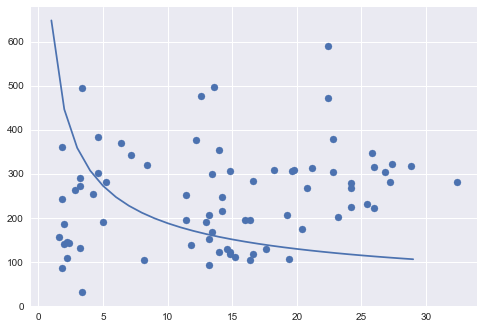

In [63]:
def calc_rate(d):
    return(round(d['dist']/(chrons[d['start']]-chrons[d['end']])/10,1))
chrons_ages=pd.DataFrame(data=chrons,index=range(2)).transpose()
chrons_ages[1]=chrons_ages[0].shift(-1)
chrons_ages['time']=(chrons_ages[1]-chrons_ages[0])
distes=pd.DataFrame(distances,columns=['line','start','end','dist'])
distes['sp_rate']=distes.apply(calc_rate,axis=1)
rough_rate=pd.merge(distes,RMS_for_sns,left_on=['line','start'],right_on=['line','chron'])
# sns.jointplot('sp_rate','RMS roughness TWT',data=rough_rate)
plt.scatter(rough_rate['sp_rate']*2,rough_rate['RMS roughness TWT'])
plt.plot([i for i in range(0,30,1)], [1296*np.power(i,-0.539)/2 for i in range(0,30,1)])
plt.show()

In [13]:
def calc_distance(name):
    one_line=result[result['line']==name]
    chrons_on_line=one_line[one_line['name'].notnull()].name.values
    if chrons[chrons_on_line[0]]<chrons[chrons_on_line[-1]]:
        one_line=one_line.reindex(index=one_line.index[::-1])
        one_line.index=range(len(one_line))
        chrons_on_line=one_line[one_line['name'].notnull()].name.values
    print(name,chrons_on_line)
    index=one_line[one_line['name'].notnull()].name.index
    min_chron=one_line[one_line['name'].notnull()].index.min()
    max_chron=one_line[one_line['name'].notnull()].index.max()
    one_line=one_line.loc[min_chron:max_chron]
    one_line.index=range(len(one_line))
    index=one_line[one_line['name'].notnull()].name.index
    new_depth=[]
    regression=[]
    space_on_start=5398-chrons[chrons_on_line[0]]
    dists=[]
    for i in range(len(chrons_on_line)-1):
        start=one_line[one_line['name']==chrons_on_line[i]].index[0]
        end=one_line[one_line['name']==chrons_on_line[i+1]].index[0]
        distance=(abs(one_line.loc[start,'x']-one_line.loc[end,'x'])**2+abs(one_line.loc[start,'y']-one_line.loc[end,'y'])**2)**0.5
        print([name,chrons_on_line[i+1],distance])
        dists.append([name,chrons_on_line[i],chrons_on_line[i+1],distance])
    return(dists)
distances=[]
for i in result.line.unique():
    if i not in ['Arc11005_04','Arc11006_02','Arc11005_06']:
        distances.extend(calc_distance(i))

Arc11003 ['C24no' 'C21no' 'C21any' 'C20no' 'C13ny']
['Arc11003', 'C21no', 80357.325750610296]
['Arc11003', 'C21any', 15483.971425974685]
['Arc11003', 'C20no', 14911.602142928832]
['Arc11003', 'C13ny', 62622.855900497707]
Arc11035 ['C21no' 'C20no' 'C16ny']
['Arc11035', 'C20no', 53000.596075268775]
['Arc11035', 'C16ny', 24136.456481184257]
Arc11005 ['C24no' 'C21no' 'C21any' 'C20no' 'C13ny']
['Arc11005', 'C21no', 86396.648368105074]
['Arc11005', 'C21any', 13333.378314939529]
['Arc11005', 'C20no', 16944.852332685001]
['Arc11005', 'C13ny', 58754.110597588857]
Arc11006 ['C24no' 'C21no' 'C21any' 'C20no' 'C13ny']
['Arc11006', 'C21no', 70344.927881874304]
['Arc11006', 'C21any', 15702.115182382255]
['Arc11006', 'C20no', 18750.553174714627]
['Arc11006', 'C13ny', 71918.089522679918]
Arc11006_10 ['C20no' 'C13ny' 'C06no' 'C05ny']
['Arc11006_10', 'C13ny', 68117.846507757393]
['Arc11006_10', 'C06no', 56857.489585907708]
['Arc11006_10', 'C05ny', 69878.41767772357]
Arc11024 ['C20no' 'C16ny' 'C13ny' 'C06

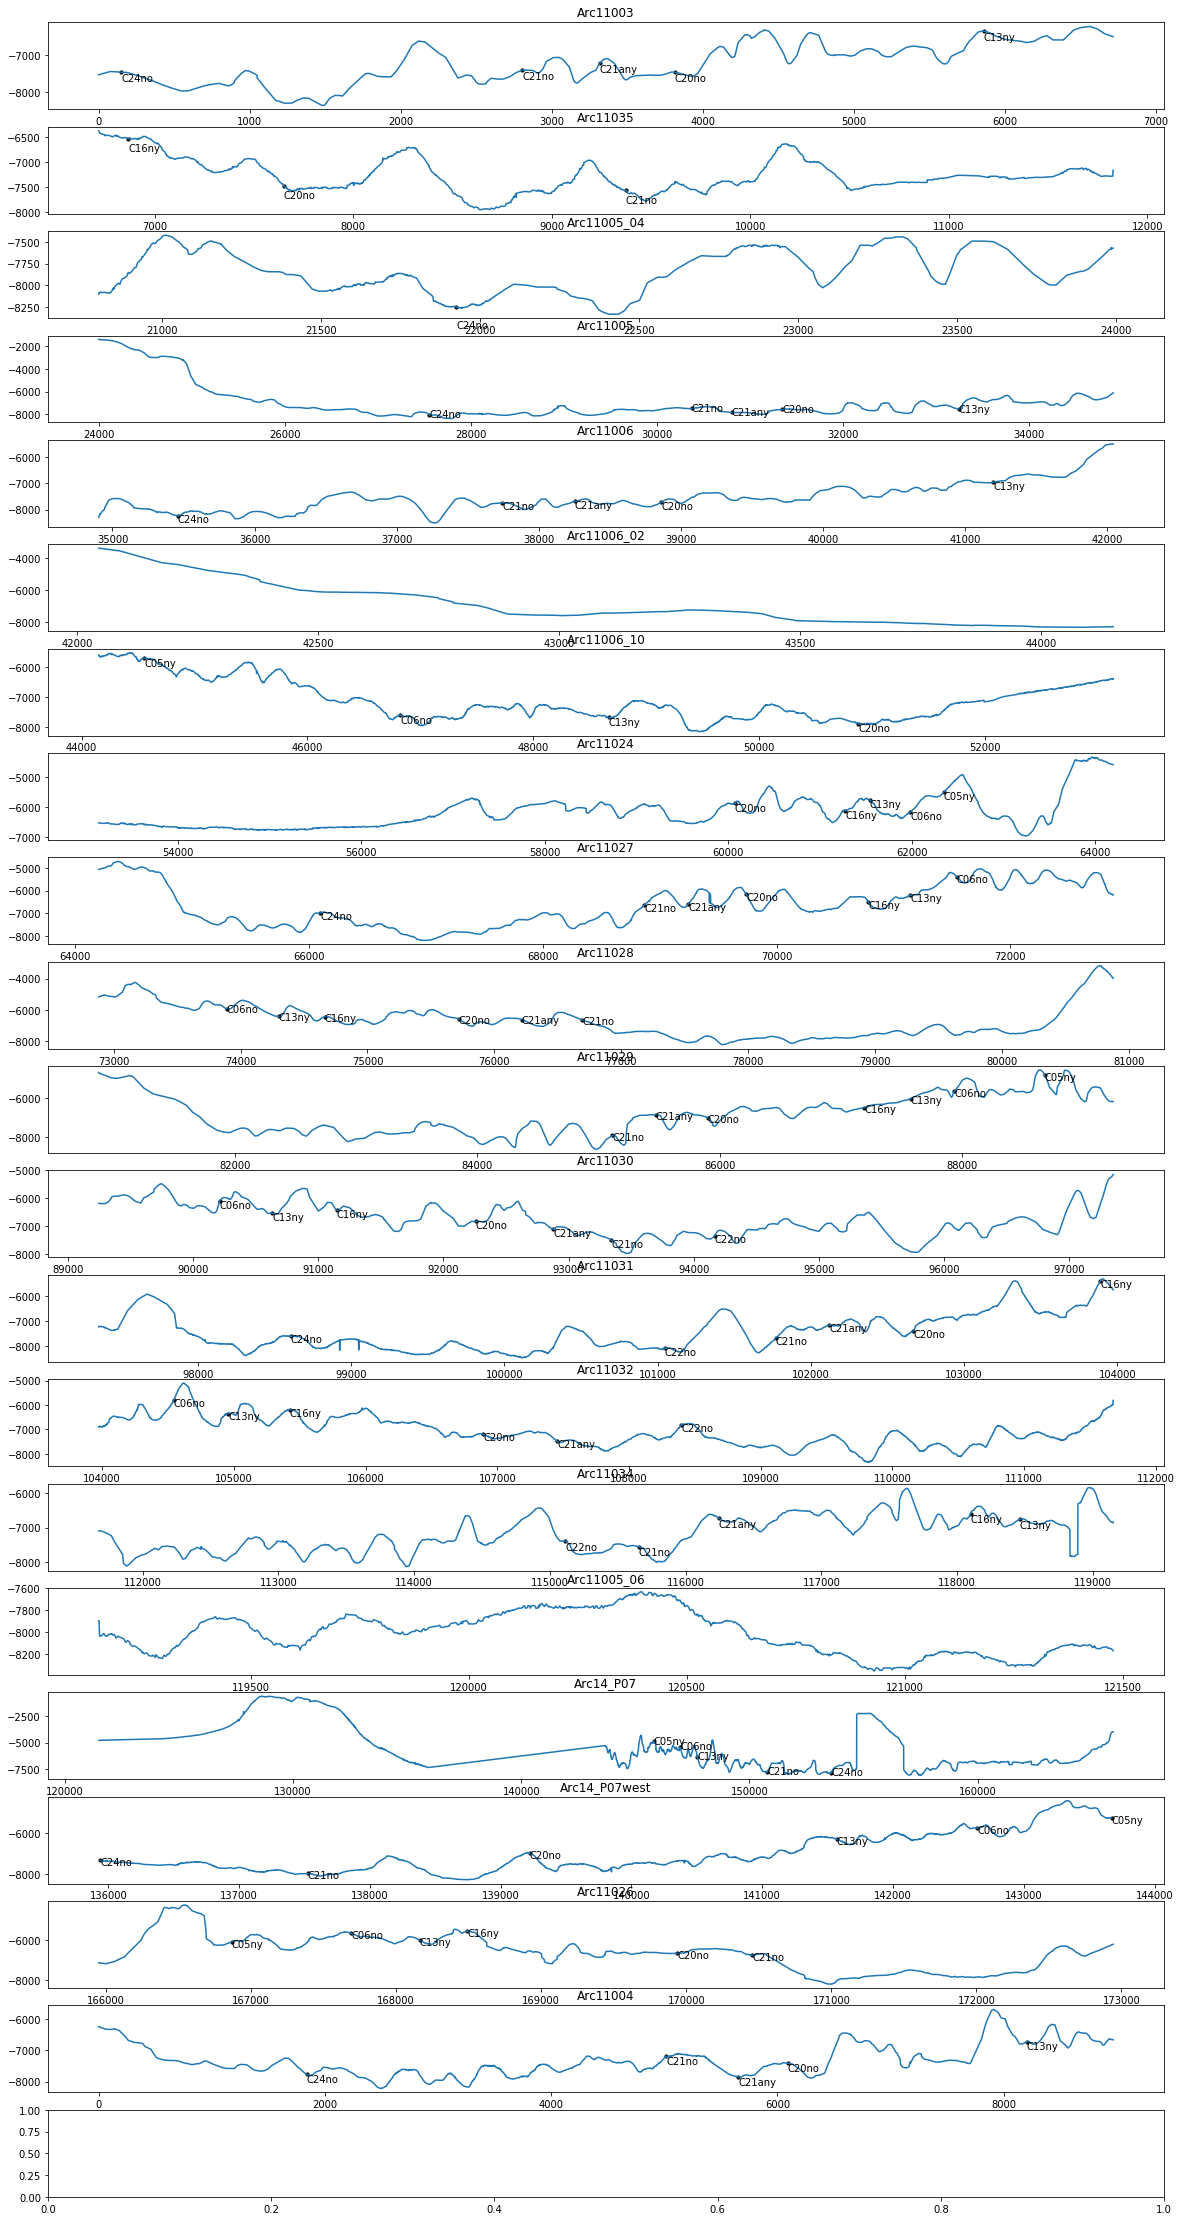

In [321]:

f, axarr = plt.subplots(21,1, figsize=(20,40))
q=0
for j in result.line.unique():
    one_line=result[result['line']==j]
    axarr[q].plot(-one_line['depth_x'])
    axarr[q].set_title(j) 
    for i in one_line[one_line.name.notnull()==True].index:
        axarr[q].text(x=i,y=-one_line.loc[i,'depth_x']-250,s=one_line.loc[i,'name'])
        axarr[q].scatter(x=i,y=-one_line.loc[i,'depth_x'],s=10,c='black')
    q+=1
plt.savefig('result.svg')    
plt.show()

In [346]:
result_DB[result_DB['Arc11003'].notna()]

,res,Arc11003,Arc11035,Arc11005,Arc11006,Arc11006_10,Arc11024,Arc11027,Arc11028,Arc11029,Arc11030,Arc11031,Arc11032,Arc11034,Arc14_P07,Arc14_P07west,Arc11026,Arc11004
0,NaN,-417.689446,NaN,-151.595853,-39.013312,NaN,NaN,-601.495384,NaN,NaN,NaN,-501.515827,NaN,NaN,256.076293,-671.557148,NaN,-380.111672
1,NaN,-393.986555,NaN,114.869704,181.853275,NaN,NaN,-444.954092,NaN,NaN,NaN,-756.403959,NaN,NaN,290.899391,-903.115410,NaN,-99.779385
2,NaN,-398.978742,NaN,59.861284,121.272283,NaN,NaN,-497.598320,NaN,NaN,NaN,-678.778460,NaN,NaN,299.530232,-830.622872,NaN,-168.093727
3,NaN,-393.610024,NaN,113.400690,152.615569,NaN,NaN,-473.122864,NaN,NaN,NaN,-710.921814,NaN,NaN,317.743079,-870.226985,NaN,-116.603100
4,NaN,-394.947064,NaN,94.968597,137.746575,NaN,NaN,-499.102581,NaN,NaN,NaN,-689.157525,NaN,NaN,311.881217,-831.114433,NaN,-141.234455
5,NaN,-391.259861,NaN,126.627708,146.911737,NaN,NaN,-490.114841,NaN,NaN,NaN,-711.660089,NaN,NaN,317.157790,-841.897962,NaN,-109.885358
6,NaN,-391.630067,NaN,105.171887,111.831617,NaN,NaN,-512.325191,NaN,NaN,NaN,-687.756315,NaN,NaN,324.541812,-812.447516,NaN,-122.550249
7,NaN,-388.550016,NaN,118.499589,101.090339,NaN,NaN,-509.802339,NaN,NaN,NaN,-703.129330,NaN,NaN,324.862091,-830.261761,NaN,-101.337839
8,NaN,-388.570766,NaN,101.432236,81.945554,NaN,NaN,-525.143002,NaN,NaN,NaN,-674.302594,NaN,NaN,329.675194,-814.407369,NaN,-123.719358
9,NaN,-384.904925,NaN,107.042478,74.521883,NaN,NaN,-510.558525,NaN,NaN,NaN,-693.853326,NaN,NaN,330.782293,-814.396425,NaN,-119.335749


In [175]:
vel27=pd.read_csv('027VEL.dat',sep=' ',names=['X','Y','TWT','velocity','CDP'],usecols=[0,1,2,4,6])
CDP=vel27.groupby(['CDP'])[['X','Y']].mean()
one_line=data[data['line']=='Arc11027']

In [141]:
a=[]
one_line=result[result['line']=='Arc11027']
one_line['CDP']=range(len(one_line))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
for i in one_line.index:
    x=one_line.loc[i,'x']
    y=one_line.loc[i,'y']
    CDP['x_new']=abs(CDP.X-x)
    CDP['y_new']=abs(CDP.Y-y)
    CDP['dist']=(CDP['x_new']**2+CDP['y_new']**2)**0.5
    min_dist=CDP['dist'].min()
    a.append(CDP['dist'].idxmin())

In [59]:
one_line['CDP']=a[1:]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [177]:
one_line['TWT']=one_line['depth_x']
def convert_velocities(row):
    res= row['TWT']
    if res%30<15: res=res//30*30
    else: res=res//30*30+30
    return(vel27[(vel27['CDP']==row['CDP']) & (vel27['TWT']<=res)]['velocity'].sum()*0.015)
one_line['Depth']=one_line.apply(convert_velocities,axis=1)

KeyError: 'depth_x'

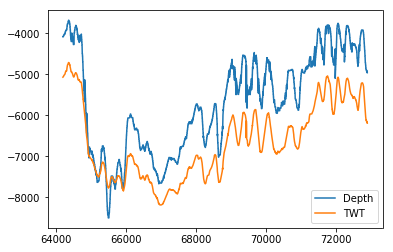

In [98]:
plt.plot(-one_line['Depth'])
plt.plot(-one_line['TWT'])
plt.legend()
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


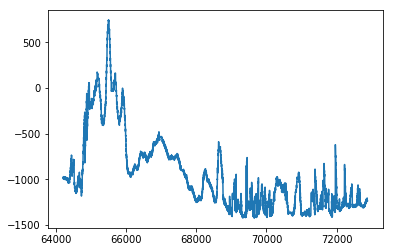

In [101]:
one_line['diff']=one_line['Depth']-one_line['TWT']
plt.plot(one_line['diff'])
plt.show()

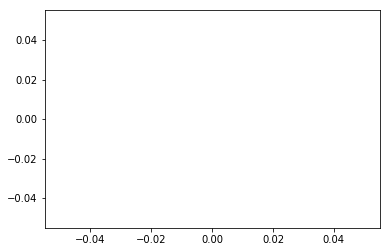

In [173]:
plt.scatter(vel27[vel27.CDP==1080]['velocity'],-vel27[vel27.CDP==1080.0]['TWT'])
plt.show()

In [122]:
for i in one_line.index:
    
    CDP=one_line.loc[i,'CDP']
    TWT=one_line.loc[i,'TWT']
    mx=vel27[(vel27['CDP']==CDP) & (vel27['TWT']<=TWT) & (vel27['TWT']>TWT-62)]['velocity'].max()
    mn=vel27[(vel27['CDP']==CDP) & (vel27['TWT']<=TWT) & (vel27['TWT']>TWT-62)]['velocity'].min()
    if mx>5000: print(mx,mn,TWT,CDP,' warning!')

5238.8 4750.3 7411.556 1575.0  warning!
5238.8 4772.4 7413.778 1575.0  warning!
5238.8 4772.4 7416.0 1575.0  warning!
5238.8 4772.4 7418.0 1575.0  warning!
5238.8 4772.4 7420.0 1575.0  warning!
5238.8 4772.4 7422.0 1575.0  warning!
5238.8 4772.4 7424.0 1575.0  warning!
5238.8 4772.4 7436.0 1575.0  warning!
5238.8 4772.4 7438.0 1575.0  warning!
6525.7 4772.4 7440.0 1575.0  warning!
6525.7 5238.8 7442.0 1575.0  warning!
6525.7 5238.8 7444.0 1575.0  warning!
6525.7 5238.8 7446.0 1575.0  warning!
6525.7 5238.8 7448.0 1575.0  warning!
6525.7 5238.8 7450.0 1575.0  warning!
6525.7 5238.8 7452.0 1575.0  warning!
6525.7 5238.8 7454.03 1575.0  warning!
6525.7 5238.8 7456.06 1575.0  warning!
6525.7 5238.8 7458.09 1575.0  warning!
6525.7 5238.8 7460.12 1575.0  warning!
6525.7 5238.8 7458.286999999999 1575.0  warning!
6525.7 5238.8 7458.973000000001 1575.0  warning!
6525.7 5238.8 7461.275 1575.0  warning!
6525.7 5238.8 7462.7609999999995 1575.0  warning!
6525.7 5238.8 7464.246 1575.0  warning!
6525

6751.9 6742.7 7602.0 1812.0  warning!
6751.9 6742.7 7595.429 1812.0  warning!
6742.7 6733.6 7588.857 1812.0  warning!
6742.7 6733.6 7582.286 1812.0  warning!
6742.7 6733.6 7575.714 1812.0  warning!
6742.7 6733.6 7569.143 1812.0  warning!
6742.7 6733.6 7562.571 1812.0  warning!
6733.6 6724.4 7556.0 1812.0  warning!
6733.6 6724.4 7554.222 1812.0  warning!
6733.6 6724.4 7552.444 1812.0  warning!
6733.6 6724.4 7550.6669999999995 1812.0  warning!
6733.6 6724.4 7548.889 1812.0  warning!
6733.6 6724.4 7547.111 1812.0  warning!
6733.6 6724.4 7545.3330000000005 1812.0  warning!
6733.6 6724.4 7543.556 1812.0  warning!
6733.6 6724.4 7541.778 1812.0  warning!
6733.6 6724.4 7540.0 1812.0  warning!
6733.6 6724.4 7538.222 1812.0  warning!
6733.6 6724.4 7536.444 1812.0  warning!
6733.6 6724.4 7534.6669999999995 1812.0  warning!
6733.6 6724.4 7532.889 1812.0  warning!
6733.6 6715.3 7531.111 1812.0  warning!
6724.4 6715.3 7516.0 1812.0  warning!
6724.4 6715.3 7515.0 1812.0  warning!
6720.5 6711.3 7514.0

KeyboardInterrupt: 

In [138]:
one_line

,x,y,line,depth_x,name
64200,585875.24,670114.04,Arc11027,5070.627,NaN
64201,585887.11,670100.05,Arc11027,5070.679,NaN
64202,585898.99,670086.05,Arc11027,5069.010,NaN
64203,585910.87,670072.05,Arc11027,5067.340,NaN
64204,585922.74,670058.06,Arc11027,5065.670,NaN
64205,585934.62,670044.06,Arc11027,5064.000,NaN
64206,585946.50,670030.07,Arc11027,5063.070,NaN
64207,585958.37,670016.07,Arc11027,5062.141,NaN
64208,585970.25,670002.07,Arc11027,5061.211,NaN
64209,585982.12,669988.08,Arc11027,5060.281,NaN


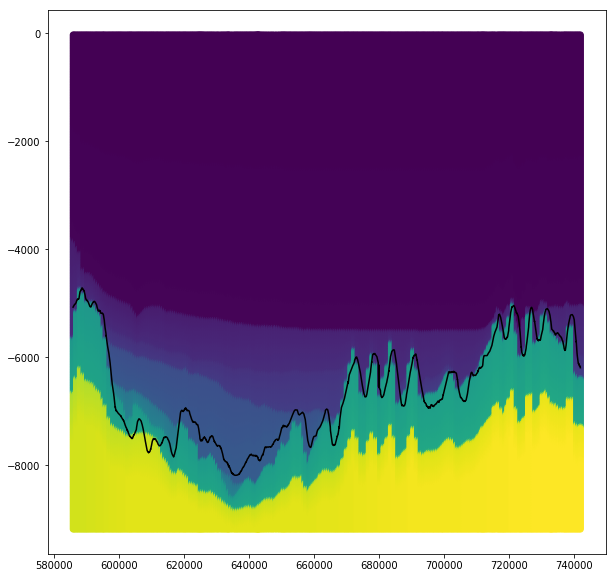

In [176]:
plt.figure(figsize=(10,10))
plt.scatter(vel27['X'],vel27['TWT'], c=vel27['velocity'])
plt.plot(one_line['x'],-one_line['depth'],c='black')
plt.show()

In [174]:
vel27

,X,Y,TWT,velocity,CDP
0,585928.93,670049.92,-0.0,-0.0,1450.10
1,585928.93,670049.92,-30.0,-30.0,ARC_027
2,585928.93,670049.92,-60.0,-60.0,ARC_027
3,585928.93,670049.92,-90.0,-90.0,ARC_027
4,585928.93,670049.92,-120.0,-120.0,ARC_027
5,585928.93,670049.92,-150.0,-150.0,ARC_027
6,585928.93,670049.92,-180.0,-180.0,ARC_027
7,585928.93,670049.92,-210.0,-210.0,ARC_027
8,585928.93,670049.92,-240.0,-240.0,ARC_027
9,585928.93,670049.92,-270.0,-270.0,ARC_027
